In [2]:
#from util import *
import os, shutil
import pandas as pd

from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap
from elecpy.elecpySession import ElecpySession


In [3]:
from opmap.cmap import bipolar

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm
import copy

%matplotlib inline

In [5]:
src_dir = '/mnt/recordings/SimulationResult/'
save_dir = '/mnt/recordings/AnalysisResult/Tomii/2018-09-04/'
print(save_dir)
if not os.path.exists(save_dir) : os.mkdir(save_dir)

/mnt/recordings/AnalysisResult/Tomii/2018-09-04/


In [6]:

def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value


In [7]:
def analyzeSession(sess, save_dir=None):
    cam = VideoData(*sess.data['vmem'].shape)
    cam.data = - sess.data['vmem']
    v = VmemMap(cam);del(cam)
    p = PhaseMap(v, width = v.data.shape[2]); 
    p.data = - p.data
    pv = PhaseVarianceMap(p, size=3)
    
    if save_dir is not None:
        v.saveImage( os.path.join(save_dir, 'vmem'))
        p.saveImage( os.path.join(save_dir, 'pmap'))
        pv.saveImage( os.path.join(save_dir, 'pvmap'))

    sess.data['phase'] = p.data
    sess.data['pv'] = pv.data

In [8]:
def plot_phase_surface(sess, frame, cut_thre = 2*np.pi*0.75, angle=0):
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim3d(-np.pi, np.pi)

    _, size_h, size_w = sess.data['phase'].shape

    y = np.arange(size_h)
    x = np.arange(size_w)
    X, Y = np.meshgrid(x, y)
    Z = sess.data['phase'][frame, ::-1, :]
    
    if angle is 1: Z = Z.T[:,::-1]
    if angle is 2: Z = Z[::-1,::-1]
    if angle is 3: Z = Z.T[::-1,:]

    wire = ax.plot_wireframe(X, Y, Z)

    nx, ny, _  = np.shape(wire._segments3d)
    wire_x = np.array(wire._segments3d)[:, :, 0].ravel()
    wire_y = np.array(wire._segments3d)[:, :, 1].ravel()
    wire_z = np.array(wire._segments3d)[:, :, 2].ravel()
    wire.remove()

    # create data for a LineCollection
    wire_x1 = np.vstack([wire_x, np.roll(wire_x, 1)])
    wire_y1 = np.vstack([wire_y, np.roll(wire_y, 1)])
    wire_z1 = np.vstack([wire_z, np.roll(wire_z, 1)])

    to_delete = np.arange(0, nx*ny, ny)
    wire_x1 = np.delete(wire_x1, to_delete, axis=1)
    wire_y1 = np.delete(wire_y1, to_delete, axis=1)
    wire_z1 = np.delete(wire_z1, to_delete, axis=1)
    scalars = np.delete(wire_z, to_delete)

    segs = np.array([list(zip(xl, yl, zl)) for xl, yl, zl in \
                 zip(wire_x1.T, wire_y1.T, wire_z1.T)])

    # delete false phase discontinuity
    to_delete = np.where( np.array([ abs( seg[0][2] - seg[1][2]) for seg in segs ]) > cut_thre)[0]
    segs = np.delete( segs, to_delete, axis=0)
    scalars = np.delete( scalars, to_delete)

    # Plots the wireframe by a  a line3DCollection
    my_wire = art3d.Line3DCollection(segs, cmap="jet")
    my_wire.set_array(scalars)
    my_wire.set_clim(vmin=-np.pi, vmax=np.pi)
    ax.add_collection(my_wire)

    plt.colorbar(my_wire)



## Check whole dynamics

In [7]:
df = pd.read_csv('data.whole.csv')
df

,sim_id,gna,gkr,gks,description
0,20180525-1,12.0,0.0125,0.13860,normal <<< 20171128-1
1,20180616-1,10.0,0.0125,0.13860,vortex shedding <<< 20171128-1
2,20180625-1,15.6,0.0088,0.09702,APD prolongation <<< 20171128-1
3,20180823-1,12.0,0.0125,0.13860,pinning <<< 20171128-1


/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180525-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180616-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180616-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180625-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180625-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180625-1
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180823-1


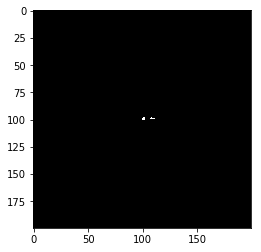

In [12]:

for i, row in df.iterrows():
    
    #if i not in [3]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    sess = ElecpySession( os.path.join(src_dir, row.sim_id), keys=['vmem'])
    
    analyzeSession(sess, save_dir=dst_dir)
    
    plt.imshow(np.sum(sess.data['pv'][100:-100,:,:] > 0.3, axis=0), cmap='gray')
    plt.savefig(os.path.join(dst_dir, 'traj.png'))
    

## Check region detail

In [852]:
df = pd.read_csv('data.roi.csv')
df

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20180525-1,135,165,85,115,290,330,-,control
1,20180823-1,80,120,80,120,105,175,A,pinning
2,20180625-1,110,150,80,120,120,160,C,meandering
3,20180625-1,160,200,80,120,220,260,D,spiral stop
4,20180616-1,80,120,80,120,360,400,B,over the trajectory of vortex shedding


In [866]:
thre_phase_integ = np.pi*1.5

In [869]:
for i, row in df.iterrows():
    
    if i not in range(1,5): continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    
    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max
    )
    
    analyzeSession(sess, save_dir=dst_dir)
    sess.setRange(
        f_min = row.f_min,
        f_max = row.f_max,
    )

    p = sess.data['phase']
    
    ### Vmem(raw) ###
    if False:
        path = os.path.join(dst_dir,'vmem_raw')
        if not os.path.exists(path) : os.mkdir(path)
        vmin = sess.data['vmem'].min()
        vmax = sess.data['vmem'].max()
        for f, vmem in enumerate(sess.data['vmem']):
            plt.imsave(
                os.path.join(path, '{0:0>4}.png'.format(f)), 
                vmem, 
                cmap=bipolar(neutral=0, lutsize=1024),
                vmin=vmin, vmax=vmax)
    
    ### 3D phase plot ###
    if False:
        for angle in range(4):

            path = os.path.join(dst_dir,'psurf_{0}'.format(angle))
            if not os.path.exists(path) : os.mkdir(path)

            for frame in range(row.f_max-row.f_min):

                plt.clf()
                plot_phase_surface(sess, frame, angle=angle)
                plt.savefig(os.path.join(path, '{0:0>6}.png'.format(frame)))

    ### integral of time differential ###
    if True:
        p = sess.data['phase']
        v = sess.data['vmem']
        pdiff = copy.deepcopy(p)
        for f in range(len(pdiff)):
            if f == 0: 
                pdiff[f,:,:] = 0
            else:
                pdiff[f,:,:] = p[f,:,:] - p[f-1,:,:]
        pdiff = phaseComplement(pdiff)
        pinteg = abs(np.sum(pdiff, axis=0))

        plt.clf()
        plt.imshow(pinteg, vmin=0, cmap='gray') # vmax=2*np.pi, 
        plt.colorbar()
        plt.savefig(os.path.join(dst_dir, 'pinteg.png'))
    
        pos_y, pos_x = np.where(pinteg > thre_phase_integ)
        neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
        
        plt.clf()
        plt.subplot(2,2,1)
        for y, x in zip(neg_y, neg_x):
            if x == p.shape[2]//2:
                plt.plot(v[:,y,x], 'b')
                plt.ylim([v.min(), 20])
        plt.subplot(2,2,2)
        for y, x in zip(neg_y, neg_x):
            if x == p.shape[2]//2:
                plt.plot(p[:,y,x], 'b')
        plt.subplot(2,2,3)
        for y, x in zip(pos_y, pos_x):
            if x == p.shape[2]//2:
                plt.plot(v[:,y,x], 'r')
                plt.ylim([v.min(), 20])
        plt.subplot(2,2,4)
        for y, x in zip(pos_y, pos_x):
            if x == p.shape[2]//2:
                plt.plot(p[:,y,x], 'r')
        plt.savefig(os.path.join(dst_dir, 'border_plot.png'))
        plt.close()

    
    ### phase graph (circular plot) ###
    if False:
        path = os.path.join(dst_dir,'border_plot')
        if not os.path.exists(path) : os.mkdir(path)
        for f in range(len(p)):

            plt.figure(figsize=(5,5))
            plt.clf()

            phases = np.arange(0,2*np.pi,np.pi/1024)
            plt.scatter( np.cos(phases), np.sin(phases), c='k', s=.02)

            A = np.arange(-1.2, 1.2, 0.01)
            plt.scatter( A, np.zeros_like(A), c='k', s=.02)
            plt.scatter( np.zeros_like(A), A, c='k', s=.02)

            pos_y, pos_x = np.where(pinteg > thre_phase_integ)
            for y, x in zip(pos_y, pos_x):
                if x == p.shape[2]//2:
                    phases = p[f,y,x]
                    plt.scatter( np.cos(phases), np.sin(phases), c='r', s=10)

            neg_y, neg_x = np.where(pinteg <= thre_phase_integ)
            for y, x in zip(neg_y, neg_x):
                if x == p.shape[2]//2:
                    phases = p[f,y,x]
                    plt.scatter( np.cos(phases), np.sin(phases), c='b', s=10)

            plt.axis('equal')
            plt.axis([-1.2, 1.2, -1.2, 1.2])
            plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
            plt.close()

    ### spatial phase differential ###
    if False:
        path = os.path.join(dst_dir,'polarity')
        if not os.path.exists(path) : os.mkdir(path)

        H = p.shape[1]
        W = p.shape[2]
        pdiff_x = np.zeros(( H  , W-1))
        pdiff_y = np.zeros(( H-1, W  ))
        plt.clf()
        
        for f in range(len(p)):

            plt.clf()
            fig, ax = plt.subplots(figsize=(10,10))
            plt.axis('equal')
            ax = plt.gca()
            plt.axis([0, H, 0, W])
            ax.tick_params(labelbottom="off", labelleft="off")
            ax.tick_params(bottom="off", left="off")
            ax.tick_params(top="off", right="off")
            ax.axis("off")
            #plt.style.use('dark_background')

            #plt.subplot(121)
            #plt.imshow(p[f], cmap='jet', vmin=-np.pi, vmax=np.pi)
            #plt.subplot(122)
            cm = bipolar(neutral=0, lutsize=1024)
            pdiff_y = p[f,1:,:] - p[f,:-1,:]
            pdiff_x = p[f,:,1:] - p[f,:,:-1]

            plt.plot( [0,0,W,W,0], [0,H,H,0,0], color='black')
            
            for j in range(W-1):
                
                x = np.ones(H+1)*(j+1)
                y = np.arange(H+1)
                
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                
                lc = mcoll.LineCollection(
                    segments, array=-np.cos(pdiff_x[::-1,j]), 
                    cmap=plt.cm.coolwarm, 
                    norm=plt.Normalize(-1.25, 1.0),
                    linewidth=1, alpha=1.0)
                ax.add_collection(lc)
                
            for i in range(H-1):
                
                y = np.ones(W+1)*(i+1)
                x = np.arange(W+1)
                
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                
                lc = mcoll.LineCollection(
                    segments, 
                    array=-np.cos(pdiff_y[-1-i,:]), 
                    cmap=plt.cm.coolwarm, 
                    norm=plt.Normalize(-1.25, 1.0),
                    linewidth=1, alpha=1.0)
                ax.add_collection(lc)    

            plt.savefig(
                os.path.join(path, '{0:0>6}.png'.format(f)),
                transparent=True, 
                bbox_inches='tight'
            )
            plt.close()
        
        
    ### Trajectory ###
    if False:
        plt.clf()
        plt.imshow(np.sum(sess.data['pv'], axis=0)>0, cmap='gray')
        plt.colorbar()
        plt.savefig(os.path.join(dst_dir, 'traj.png'))
    

/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180823-1/x80-120_y80-120_f105-175
('cell/xina', 201, 201)
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180625-1/x110-150_y80-120_f120-160
('cell/xina', 501, 501)
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180625-1/x160-200_y80-120_f220-260
('cell/xina', 501, 501)
/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180616-1/x80-120_y80-120_f360-400
('cell/xina', 1001, 1001)


## Total sodium current

In [190]:
df = pd.read_csv('data.roi-Ina.csv')
df

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20180910-1,80,120,80,120,1050,1690,B,pinning


/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180910-1/x80-120_y80-120_f1050-1690
('cell/xina', 2001, 2001)


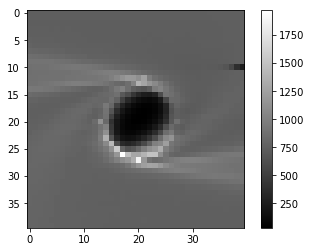

In [29]:
for i, row in df.iterrows():
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    
    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max,
        f_min = row.f_min,
        f_max = row.f_max,
    )

    
    ### Sodium current integral ###
    
    xina = abs(np.sum(sess.data["cell/xina"], axis=0))
    plt.clf()
    plt.imshow(xina, cmap='gray')
    plt.colorbar()
    plt.savefig(os.path.join(dst_dir, 'xina.png'))
    

## Shift speed analysis

In [830]:
r = 5

In [831]:
df = pd.read_csv('data.roi-speed.csv')
df

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20180525-1,135,165,85,115,290,330,-,control
1,20180823-1,80,120,80,120,105,175,A,pinning
2,20180625-1,10,190,10,190,50,200,C,meandering
3,20180625-1,160,200,80,120,220,244,D,spiral stop
4,20180616-1,0,200,0,200,22,520,B,over the trajectory of vortex shedding


In [832]:
def lkf2d(Y):

    A = np.eye(4)
    A[0,2] = 1.
    A[1,3] = 1.
    B = np.eye(4)
    Q = np.eye(4)
    C = np.eye(4)
    R = np.eye(4)*2.0
    C = np.eye(4)
    R = np.eye(4)

    Sigma = np.zeros((4,4))
    mu = Y[0]
    M = [mu]

    for i in range(1,len(Y),1):

        # 推定
        mu_ = np.dot(A, mu) #+ np.dot(B, U[i])
        Sigma_ = Q + np.dot(np.dot(A , Sigma) , A.T)

        # 更新
        yi = Y[i][:,np.newaxis] - np.dot(C , mu_)
        S = np.dot(np.dot(C , Sigma_), C.T) + R
        K = np.dot(np.dot(Sigma_ , C.T) , np.linalg.inv(S))
        mu = mu_ + np.dot( K , yi )
        Sigma = Sigma_ - np.dot( np.dot(K , C) , Sigma_)
        M.append(mu[:,0])

    M = np.array(M)
    return M


In [850]:
out = []

for i, row in df.iterrows():
    
    if not i in [4]: continue
        
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)


    sess = ElecpySession("/mnt/recordings/SimulationResult/"+row.sim_id, keys=['vmem', 'cell/xina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max
    )

    analyzeSession(sess)
    sess.setRange(
        f_min = row.f_min,
        f_max = row.f_max,
    )

    pv=sess.data['pv']
    p = sess.data['phase']
    L,H,W=pv.shape

    traj = np.array([ np.unravel_index(im.argmax(), im.shape) for im in pv])
    tran = traj[1:,:] - traj[:-1,:]
    #speed = np.linalg.norm((tran[1:,:] + tran[:-1,:])/2., axis=1)
    
    Y = np.concatenate( (traj[:-1,:], tran ), axis=1)
    M = lkf2d(Y)
    speed = np.linalg.norm( M[:,2:], axis=1)
   

    for f, im in enumerate(pv):
            
        gy, gx = traj[f,:]

        if (gy-r) < 0 or (gx-r) < 0 or (gy+r) > H or (gx+r) > W or f <= 10 or f >= len(pv)-1: continue
        
        pdiff_x = (p[f,:,gx-r+1:gx+r] - p[f,:,gx-r:gx+r-1])[gy-r:gy+r,:]
        pdiff_y = (p[f,gy-r+1:gy+r,:] - p[f,gy-r:gy+r-1,:])[:,gx-r:gx+r]
        
        thre = -np.cos(np.pi-.8*np.pi)
        pdiff = np.concatenate( (pdiff_x.flatten(),pdiff_y.flatten()), axis=0)
        B = -np.cos(pdiff)
        l = np.mean( B )
        #l = np.sum( B * ( B > thre)*1.0 )
        out.append( [speed[f-1], l ])
        
        
out = np.array(out)


/mnt/recordings/AnalysisResult/Tomii/2018-09-04/20180616-1/x0-200_y0-200_f22-520
('cell/xina', 1001, 1001)


0.561608234254


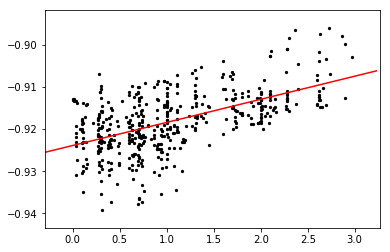

In [851]:
x = out[:,0]
y = out[:,1]

ax = plt.gca()#.set_aspect('equal', adjustable='box')
#ax.set_aspect('equal')

xmin = x.min() - (x.max()-x.min())*0.1
xmax = x.max() + (x.max()-x.min())*0.1
ymin = y.min() - (y.max()-y.min())*0.1
ymax = y.max() + (y.max()-y.min())*0.1

ax.axis([xmin, xmax, ymin, ymax])
ax.scatter(x,y, c='k', s=5)

print(np.corrcoef(x,y)[0,1])

a, b = np.polyfit(x,y,1)
xs = np.arange(xmin, xmax, (xmax-xmin)*0.01)
y2 = a*xs+b
ax.plot(xs, y2, c='r')

plt.show()

## Misc

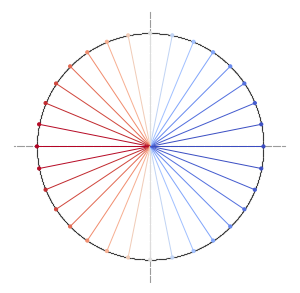

In [14]:

plt.clf()

fig, ax = plt.subplots(figsize=(5,5))
plt.axis('equal')
plt.axis([-1.2, 1.2, -1.2, 1.2])
ax = plt.gca()
ax.tick_params(labelbottom="off", labelleft="off")
ax.tick_params(bottom="off", left="off")
ax.tick_params(top="off", right="off")
ax.axis("off")

phases = np.arange(0,2*np.pi,np.pi/1024)
plt.scatter( np.cos(phases), np.sin(phases), c='k', s=.02)

A = np.arange(-1.2, 1.2, 0.01)
plt.scatter( A, np.zeros_like(A), c='k', s=.02)
plt.scatter( np.zeros_like(A), A, c='k', s=.02)

phases = np.arange(0,2*np.pi,np.pi/16)
plt.scatter( 
    np.cos(phases), np.sin(phases), 
    c=-np.cos(phases), 
    cmap=plt.cm.coolwarm,
    s=10)

segments = np.array( [[[0,0],[np.cos(theta), np.sin(theta)]] for theta in phases], dtype=np.float64)
lc = mcoll.LineCollection(
    segments, array=-np.cos(phases), 
    cmap=plt.cm.coolwarm, 
    norm=plt.Normalize(-1.0, 1.0),
    linewidth=1, alpha=1.0)
ax.add_collection(lc)

plt.show()

#plt.savefig(os.path.join(path, '{0:0>6}.png'.format(f)))
#plt.close()